# Add Environment

In [1]:
import cv2 as cv
import sys
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import h5py

# 1. Question 1

After running the code below, the resized shape of image is (480, 640, 3)



origin size (832, 1214, 3)
resize (480, 640, 3)


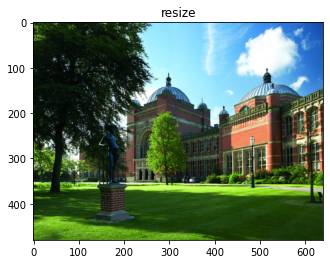

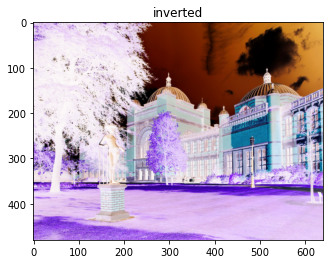

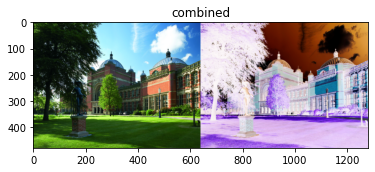

In [2]:
# (a) shape
img = cv.imread(cv.samples.findFile("./input.jpg"))
print('origin size', img.shape)

# (b) resize
resize_cols = 640
resize_rows = 480
img_resize = cv.resize(img, (resize_cols,resize_rows), interpolation = cv.INTER_AREA)
img_resize = cv.cvtColor(img_resize, cv.COLOR_BGR2RGB) # change to RGB
print('resize', img_resize.shape)

# (c) show
plt.title('resize')
plt.imshow(img_resize)

# (d) subtract for inverting
img_invert = 255 - img_resize

# (e) show inverted
plt.figure()
plt.title('inverted')
plt.imshow(img_invert)

# (f) save
Image.fromarray(img_invert).save('inverted-output.jpg')

# (g) combines
img_resize.shape, img_invert.shape
img_combined = np.concatenate((img_resize, img_invert), axis=1)

# (h) show combined
plt.figure()
plt.title('combined')
plt.imshow(img_combined)

# (i) save in h5
writeF = h5py.File("combined-output.h5", "w")
writeF.create_dataset('data', data=img_combined, dtype='i')
writeF.close()

# Question 2

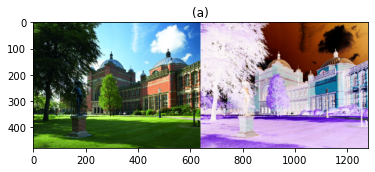

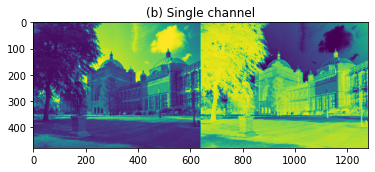

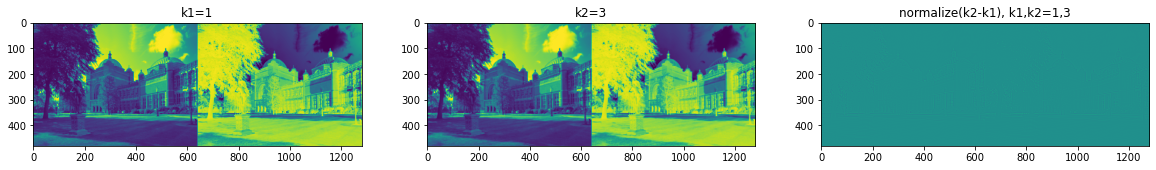

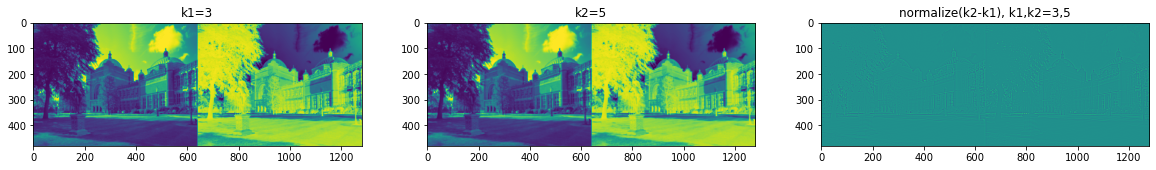

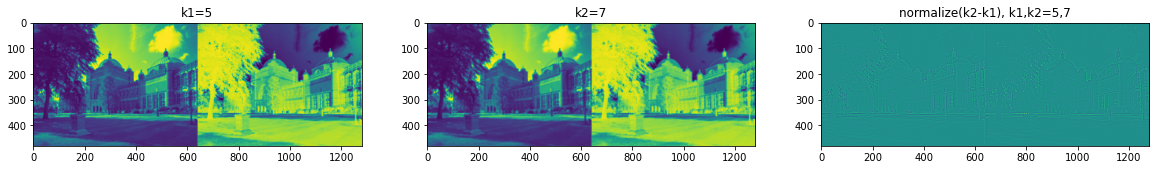

In [3]:
# (a) read and display
readF = h5py.File('combined-output.h5', 'r')
img_comb = np.array(readF['data'])
readF.close()
plt.title('(a)')
plt.imshow(img_comb)

# (b) take mean as single-channel
plt.figure()
img_comb_mean = np.mean(img_comb, axis=2)
plt.title('(b) Single channel')
plt.imshow(img_comb_mean)

# 3 sets of kernel
k1k2_sets = ((1,3),(3,5),(5,7))

# (j) repeats
for i in range(3):
  # (c) one of the three sets
  k1 = k1k2_sets[i][0]
  k2 = k1k2_sets[i][1]

  plt.figure(figsize=(20, 10))
  
  # (d) k1
  img_k1 = cv.GaussianBlur(img_comb_mean, (k1, k1), 0)
  plt.subplot(1,3,1)
  plt.title('k1={}'.format(k1))
  plt.imshow(img_k1)

  # (e) k2
  img_k2 = cv.GaussianBlur(img_comb_mean, (k2, k2), 0)
  plt.subplot(1,3,2)
  plt.title('k2={}'.format(k2))
  plt.imshow(img_k2)

  # (f) subtract
  img_sub = cv.subtract(img_k2, img_k1)

  # (g) normalize
  img_normalized = np.zeros(img_sub.shape)
  img_normalized = cv.normalize(img_sub, img_normalized, 0, 1, cv.NORM_MINMAX)
  
  # (h) display
  plt.subplot(1,3,3)
  plt.title('normalize(k2-k1), k1,k2={},{}'.format(k1,k2))
  plt.imshow(img_normalized)

  # (i) save
  writeF = h5py.File("filtered-{}-{}.h5".format(k1, k2), "w")
  writeF.create_dataset('data', data=img_normalized)
  writeF.close()


# Question 3

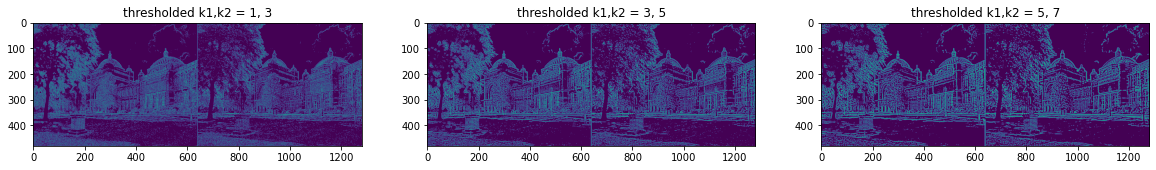

In [4]:
plt.figure(figsize=(20, 10))

# (e) repeats
for i in range(3):
  k1 = k1k2_sets[i][0]
  k2 = k1k2_sets[i][1]

  # (a) read
  readF = h5py.File("filtered-{}-{}.h5".format(k1, k2), 'r')
  img_item = np.array(readF['data'])
  readF.close()

  # (b) filter
  data_flatted = img_item.reshape((-1))
  sorted = np.sort(data_flatted)
  threshold_index = int(len(sorted) * .8)
  threshold_value = sorted[threshold_index]
  img_item[img_item < threshold_value] = 0

  # (c) display
  plt.subplot(1,3,i+1)
  plt.title('thresholded k1,k2 = {}, {}'.format(k1, k2))
  plt.imshow(img_item)

  # (d) save
  writeF = h5py.File("thresholded-{}-{}.h5".format(k1, k2), "w")
  writeF.create_dataset('data', data=img_item)
  writeF.close()

### Discussion

As we see the image, it is intuitive that when the kernel sizes are bigger, it can see more sharply and clearly. In this discussion, there use **calcHist** to explain the reason why it has this symptom.

After changing the data from normalization to normal colour ranging from 0-256, We can see from the point that. Each result has the same total pixels numbers, which are 614400, and almost the same non-zero numbers of pixels. And then, analyse the colour range in each result by **cv.calcHist** and draw **hist plot**. We can see that the smaller the kernel size is, the narrower the distribution of pixel values are located. And the *k1=1,k2=3* has the highest peak, its data is more focused than others, which make the picture slightly blurry. And the result of *k1=5,k2=7*, has a lower peak and slightly wider range in the colour distribution, and that is the reason why we can see more clearly from the image.

k1=1,k2=3, total pixels:614400, non-zero pixels: 122930
k1=3,k2=5, total pixels:614400, non-zero pixels: 122895
k1=5,k2=7, total pixels:614400, non-zero pixels: 122880


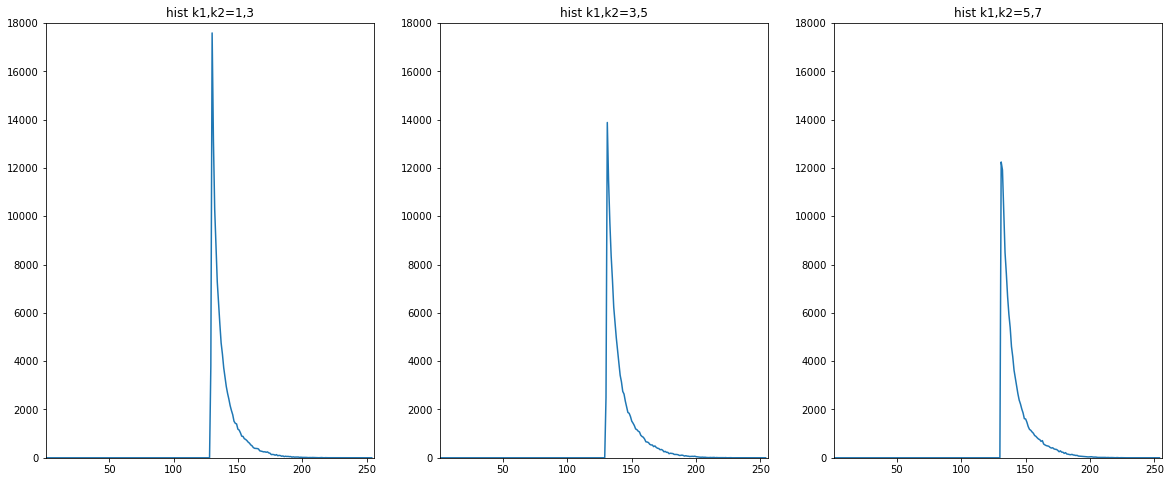

In [5]:
plt.figure(figsize=(20,8))
for i in range(3):
  k1 = k1k2_sets[i][0]
  k2 = k1k2_sets[i][1]

  readThreshold = h5py.File('thresholded-{}-{}.h5'.format(k1, k2), 'r')
  img_data = (np.array(readThreshold['data'])*255.999).astype(np.uint8)
  readThreshold.close()
    
  print('k1={},k2={}, total pixels:{}, non-zero pixels: {}'.format(
      k1, k2, len(img_data.reshape(-1)), len(img_data[img_data!=0]))
  )

  hist_data = cv.calcHist([img_data], [0], None, [256], [0,256])
  plt.subplot(1,3,i+1)
  plt.title('hist k1,k2={},{}'.format(k1, k2))
  plt.plot(hist_data[1:])# remove zero
  plt.axis((1,256,0, 18000))